<div align="center">
    
# 쏘카 메모(memo)는 어떻게 분류해야 좋을까?
</div>

### 6-1. 들어가며

<br>

**쏘카에서 해결하고자 하는 것**

---
쏘카의 수리 결과 처리를 위해 메모를 분석하고 있다.<br>
지금까지 말뭉치로부터 형태소 분석까지 진행이 되었다. 이후 어떤 과정을 거쳐야 원하는 목표에 도달할 수 있을까?

토큰화를 마친 결과물을 가지고 어떻게 의미 있는 저오를 찾아 메모의 카테고리 분류를 수행할 수 있을지 더 나아가 보자.

<br>

**학습 목표**

---
- 토큰화된 결과물을 벡터로 변환할 수 있다.
- word2vec을 훈련시키고 이용할 수 있다.
- 쏘카 메모 데이터를 활용하여 의미있는 정보를 찾아낼 수 있다.

<br>

**학습 목차**

---
1. word2vec / Fast Text
2. 키워드 추출 / 분류
3. 시각화

<br>

**준비물**

---

In [1]:
! mkdir -p ~/aiffel/socar_memo/data
! ln -s ~/data/* ~/aiffel/socar_meno/data

ln: target '/aiffel/aiffel/socar_meno/data' is not a directory


In [2]:
! pip install python-Levenshtein

`gensim` 패키지의 warning을 해결하기 위해 위의 패키지를 추가로 설치해 주어야 한다. 필수적인 것은 아니지만 해당 패키지를 설치하지 않으면 코드 동작 중에 warning이 등장할 수 있다.

### 6-2. word2vec

<br>

**Word embedding이란?**

---
Word embedding이란 비정형화된 텍스트를 컴퓨터가 이해할 수 있도록 숫자로 바꿔줌으로써 사람의 언어를 컴퓨터의 언어로 번역하는 것을 의미한다. 가장 간단하게 생각하면 단어를 모두 정수(1,2,3,...)로 변환하는 방법이 있다. 그러나 이렇게 하면 단어 사전이 늘어지는 만큼 정수도 무한히 커지게 되는 문제가 생긴다.

이 방법의 대안으로는 원핫 인코딩이라는 방법을 사용할 수도 있다. 아래 그림처럼 표현하고자 하는 단어의 인덱스 값만 1로 하고, 나머지 인덱스는 전부 0으로 표현되는 벤터로 나타내는 방법이다. 이렇게 벡터 또는 행렬의 값이 대부분 0으로 표현된느 것을 희소 표현(sparse representation)이라고 한다. 그러나 이 방법은 차원의 저주에 빠지기 쉽고, 각 단어의 유사성을 표현할 수 없다는 단점이 있다. 또, 단어 집합의 크기만큼 0이 차지하는 공간이 커지는 한계가 있다.

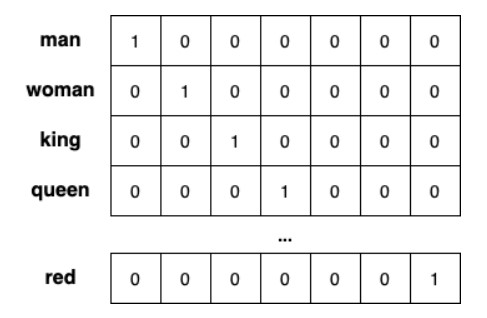

이러한 단점을 해결하기 위해 분산 표현(distributed representation)을 적용할 수 있다. 아래 그림처럼 다차원 공간에 벡터화하는 방법이다. 원핫 인코딩의 희소 표현과 달리 밀집된 벡터로 표현할 수 있는 방법이다. 원핫 인코딩에서는 각 차원이 분리된 형태로 표현되었지만, 분산 표현에서는 저차원에 여러 단어를 분산하여 표현하기 때문에 단어간 유사도를 계산할 수 있게 된다. 분산 표현을 사용하는 대표적인 예로 `word2vec`이 있다.

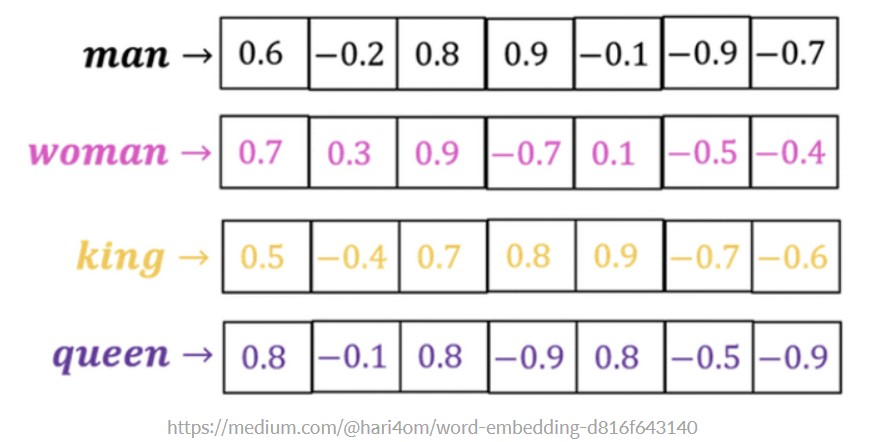

- [워드투벡터](https://wikidocs.net/22660)

<br>

**word2vec**

---
word2vec이란 단어를 벡터로 변환하는 방법 중 하나로 어떤 분포 가설을 가정하고 그에 맞춰 표현한 분산 표현을 따르는 방법이다. 기존 방법인 NNLM, RNNLM과 달리 빠른 속도로 분산 표현을 얻을 수 있어 크게 주목을 받았다.

word2vec에는 `CBOW`와 `skip-gram` 두 가지 학습 방법이 있다. 아래 그림처럼 두 방법의 가장 큰 차이는 학습 방법이다. `CBOW`는 window 단어들을 기준으로 하나의 중심 단어를 예측하는 방법이고, `skip-gram`은 하나의 중심 단어를 기준으로 window 단어들을 예측한다. 전반적인 논문들의 결과를 통해 `skip-gram`이 `CBOW`보다 더 좋은 성능으로인다고 알려져 있다.

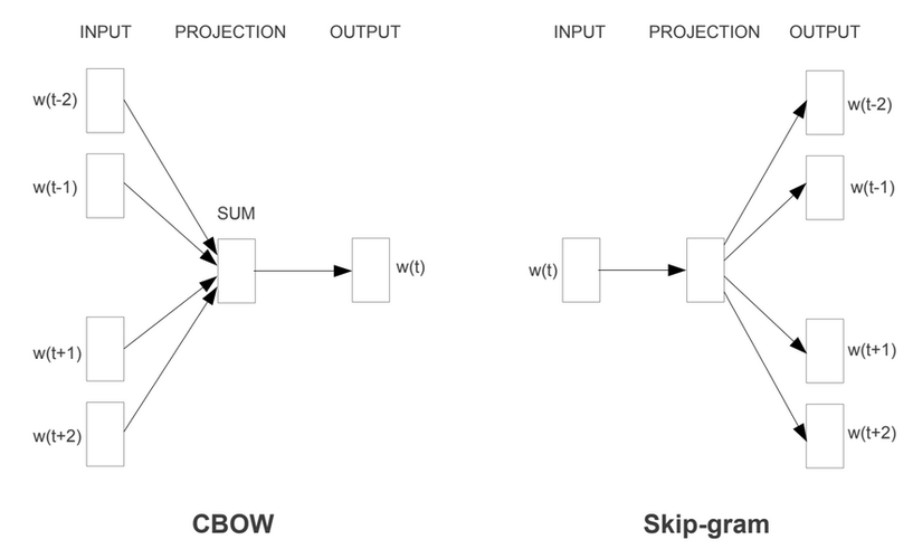

- [Efficient Estimation of Word Representations in Vector Space](https://arxiv.org/pdf/1301.3781.pdf)
- [Distributed Representations of Words and Phrases and their Compositionality](https://papers.nips.cc/paper/2013/file/9aa42b31882ec039965f3c4923ce901b-Paper.pdf)

<br>

**토큰화한 데이터를 word2vec으로 표현하기**

---
앞에서 다룬 데이터 전처리 기법 중 토큰화를 적용하여 word2vec의 학습 데이터를 만들어 보자. 지금부터는 쏘카 데이터를 사용하여 진행할 예정이다.

먼저 사용할 라이브러리를 불러오자.

In [3]:
import os
from collections import Counter
import pandas as pd
import gensim
from konlpy.tag import Komoran
import sentencepiece as spm
import matplotlib.pyplot as plt

plt.rc('font', family='NanumBarunGothic')
%config InlineBackend.figure_format = 'retina'

PATH = os.getenv('HOME') + '/aiffel/socar_memo/data'

미리 준비한 파일에는 `car_inspect_info.tsv`파일이 있다. 이는 쏘카의 수리 내역을 일부 저장한 파일이다.

확장자가 `tsv`인 파일은 `csv`파일과 비슷하게 열 수 있다. comma를 구분자로 쓰는 `csv`([Comma-separated values](https://en.wikipedia.org/wiki/Comma-separated_values))파일 형식과 비슷하게 `tsv`([Tab-separated values](https://en.wikipedia.org/wiki/Tab-separated_values))는 tab을 구분자로 사용하기 때문이다.

In [4]:
memo_data = pd.read_csv(PATH+'/car_inspect_info.tsv', sep='\t', lineterminator='\r')
memo_data.head()

,inspect_id,car_id,inspect_at,inspect_type,price,description
0,\n2504316,8421.0,2020-03-09,타이어수리(후우),6600.0,조수석뒤타이어 현장펑크수리
1,\n2401681,6654.0,2020-01-07,미션오일,120000.0,단양애니카_미션오일 교환
2,\n2384487,8563.0,2020-01-14,점화플러그,60000.0,당진세계모터스_점화플러그 교환
3,\n2384485,8563.0,2020-01-14,브레이크액,50000.0,당진세계모터스-브레이크오일 교환
4,\n2364371,6424.0,2020-01-06,브레이크액,40000.0,당진세계모터스_브레이크오일 교환


쏘카 데이터의 모습은 아래 그림과 같으며 총 273,118개의 행으로 이루어져 있다. 각 행은 6개의 열로 이루어진다. 열은 `inspect_id`, `car_id`, `inspect_at`, `inspect_type`, `price`, `description`이고, 의미는 다음과 같다.

- **inspect_id** : 수리요청 고유 번호
- **car_id** : 자동차 고유 번호
- **inspect_at** : 수리요청 발생 시간
- **inspect_type** : 수리요청 카테고리
- **price** : 수리 비용
- **description** : 수리 관련 메모

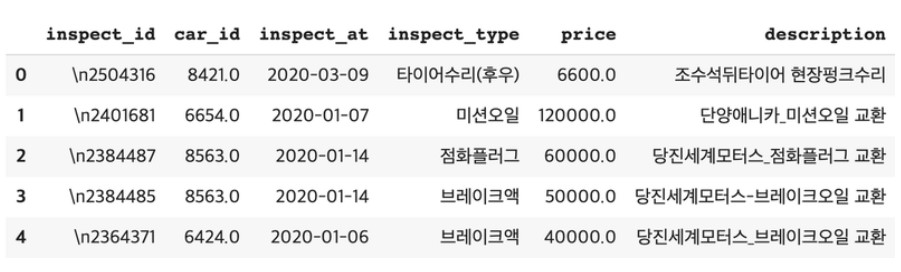

메모를 분석함에 있어서 필요한 열만 추리는 작업을 진행해 보자.

앞으로 `inspect_id`, `car_id`, `price`는 사용하지 않을 예정이니 drop한다.

In [5]:
# drop columns
memo_data = memo_data.drop(columns=['inspect_id', 'car_id', 'price'])

데이터가 들어가지 않은 항복이 없는지 확인

In [6]:
memo_data[memo_data.isna().any(axis=1)]

,inspect_at,inspect_type,description
18,NaN,NaN,NaN
20,NaN,NaN,NaN
22,NaN,NaN,NaN
58,NaN,NaN,NaN
169,NaN,NaN,NaN
...,...,...,...
272856,NaN,NaN,NaN
272858,NaN,NaN,NaN
272860,NaN,NaN,NaN
272862,NaN,NaN,NaN


결측치 모두 삭제

In [7]:
memo_data = memo_data.dropna() # drop nan row
memo_data.head()

,inspect_at,inspect_type,description
0,2020-03-09,타이어수리(후우),조수석뒤타이어 현장펑크수리
1,2020-01-07,미션오일,단양애니카_미션오일 교환
2,2020-01-14,점화플러그,당진세계모터스_점화플러그 교환
3,2020-01-14,브레이크액,당진세계모터스-브레이크오일 교환
4,2020-01-06,브레이크액,당진세계모터스_브레이크오일 교환


이 다음으로 `description`열에 해당하는 문장을 형태소 분석기를 통하여 토큰화를 진행한다. `to_token` 함수를 통하여 문장에 포함된 특수문자 등을 공백으로 변환해주는 전처리를 진행하고, 형태소 분석기의 입력으로 넣어준다.

이 결과를 `morph_description`이라는 리스트에 모아서 원래 데이터 프레임 가장 마지막 열에 붙여 준다.

`komoran`은 공백 문장("")을 입력을 받으면 오류를 발생시키기 때문에 try-except구문을 사용해 준다.

In [8]:
komoran = Komoran()

def to_token(df, col):
    '''
    make sentence to subword sentence
    '''
    morph_description = []
    for idx, row in df.iterrows():
        memo = row[col]
    
        try: # After preprocessing memo sentence, do morph analysis
            morph_out = komoran.morphs(memo.replace('_',' ').replace('-',' ').replace('/',' ').replace('ㄴ',' ').replace('#',' ').replace('=',' ').replace(')',' ) ').replace('(',' ( '))
            morph_description.append(' '.join(morph_out))

        except: # if memo column is empty, drop all of row
            df.drop(idx, inplace=True)

    df["subword_description"] = morph_description # add column
    return df

memo_data = to_token(memo_data, "description")
memo_data.head()

,inspect_at,inspect_type,description,subword_description
0,2020-03-09,타이어수리(후우),조수석뒤타이어 현장펑크수리,조수석 뒤 타이어 현장 펑크 수리
1,2020-01-07,미션오일,단양애니카_미션오일 교환,단양 애니 카 미션 오일 교환
2,2020-01-14,점화플러그,당진세계모터스_점화플러그 교환,당진 세계 모터스 점화 플러그 교환
3,2020-01-14,브레이크액,당진세계모터스-브레이크오일 교환,당진 세계 모터스 브레이크 오일 교환
4,2020-01-06,브레이크액,당진세계모터스_브레이크오일 교환,당진 세계 모터스 브레이크 오일 교환


이제 `gemsim`을 사용하기 위해 데이터를 약간 변형해 준다.

아래 그림과 같이 라인 by 라인으로 된 1차원 리스트로 입력을 넣어주는 것이 아니라 문장이 토큰화된 형태로 입력해야 한다. 즉, 2차원 리스트의 형태로 넣어주어야 한다.

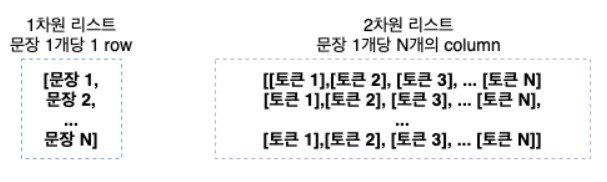

In [9]:
# 학습 데이터 정제
w2v_train = list(memo_data['subword_description'])
w2v_train = [line.split() for line in w2v_train]

print(len(w2v_train))

254141


In [10]:
w2v_train[:3]

[['조수석', '뒤', '타이어', '현장', '펑크', '수리'],
 ['단양', '애니', '카', '미션', '오일', '교환'],
 ['당진', '세계', '모터스', '점화', '플러그', '교환']]

**word2vec 옵션**

---
학습 데이터 형태를 맞췄다면 이제 word2vec에서 제공하는 옵션에 대해 알아보도록 하자.

word2vec에서 제공하는 옵션은 [여기](https://radimrehurek.com/gensim/models/word2vec.html#gensim.models.word2vec.Word2Vec)에서 확인할 수 있다.

이번 노드에서 사용할 옵션 정보는 아래와 같다.

- **vector_size**는 단어 벡터를 몇 차원으로 지정할 것인가에 대한 옵션이다. 사람들이 주로 많이 사용하는 차원은 300이다.
- **window**는 앞서 언급한 **word2vec**의 주변 단어를 의미하고, 이 크기를 사용자가 지정할 수 있다.
- **epochs**는 전체 학습 말뭉치를 몇 번 돌아서 볼 것인가를 의미한다. 딥러닝에서 에폭과 같은 개념이라고 생각하면 된다.
- **sg**는 **word2vec**의 **skip-gram**의 모형을 쓸 지, 또는 **CBOW**를 사용할지 결정하는 옵션이다. 1로 세팅하게 되면 **skip-gram**을 사용하는 것이고, 0으로 설정하게 되면 **CBOW**를 사용하는 것이다.
- **min_count**는 토근이 되기위한 최소 빈도수를 지정하는 옵션이다. 이 값을 1로 지정하게 되면 말뭉치에서 출현한 모든 단어에 대하여 단어 벡터를 만들 수 있다. 기본 값은 5이다.

<br>

**word2vec 학습 및 사용하기**

---
word2vec을 사용해 학습 진행.

In [11]:
model = gensim.models.word2vec.Word2Vec(w2v_train, 
                                        vector_size=300,
                                        window=5, 
                                        min_count=1,
                                        epochs=10)
# Save Word2Vec
model.save(PATH+'/vec300_w2v.model')
# Load Word2Ved
model = gensim.models.Word2Vec.load(PATH+'/vec300_w2v.model')

학습이 완료된 벡터를 사용하여 유사도를 표현할 수 있다. `타이어`와 유사한 단어는 무엇인지 확인해 보자.

만약 단어의 출력 개수를 조정하고 싶다면 `topn`을 수정하여 작성하면 된다.

In [12]:
# check word most similarity
model.wv.most_similar('타이어', topn=10)

[('파스', 0.42583468556404114),
 ('디스크', 0.3802679181098938),
 ('마모', 0.3725670874118805),
 ('드럼', 0.35908573865890503),
 ('어좌', 0.3483327627182007),
 ('가보', 0.34089672565460205),
 ('측면', 0.33842286467552185),
 ('뒷바퀴', 0.3354426622390747),
 ('찢', 0.3329068124294281),
 ('송정', 0.3322083353996277)]

이제 `엔진`과 가장 유사한 단어는 무엇인지 확인해보자.

In [13]:
model.wv.most_similar('엔진', topn=10)

[('소거', 0.5719588398933411),
 ('DPF', 0.5608755946159363),
 ('에어백', 0.5376434922218323),
 ('2815401', 0.5191377997398376),
 ('스캐너', 0.486803263425827),
 ('89278', 0.482632040977478),
 ('657346', 0.48042571544647217),
 ('느낌표', 0.4802257716655731),
 ('ecs', 0.4785006046295166),
 ('647654', 0.4728236198425293)]

word2vec의 결과를 통해 단어 벡터를 사용하면, 이와 관련된 유사한 단어를 얻을 수 있다. 하지만 상위 10개의 단어 중 하위에 위치한 단어는 유사성이 부족한 것을 볼 수 있다. 이 부분을 보완하기 위해 top 10의 유사도 값을 모두 더하여 평균을 내고, 이 평균값을 기준(Threshold)으로 정하여 기준보다 상위에 위치한 값을 사용하도록 한다.

In [14]:
def exclusion(word_list):
    count = sum([score for _, score in word_list])
    avg = count / len(sord_list)
    
    up_word = []
    for w, s in word_list:
        if s > avg:
            up_word.append(w)
            
    return up_word

### 6-3. FastText

<br>

**FastText**

---
단어를 벡터로 만드는 또 다른 방법으로는 Facebook의 FastText가 있다.

- [FastText](https://fasttext.cc/)

`gensim`에도 FastText가 포함되어 있다.

- [gensim.models.fasttext](https://radimrehurek.com/gensim/models/fasttext.html)

> Facebook Open source인 FastText와 gensim의 FastText의 차이
>> This module contains a fast native C implementation of fastText with Python interfaces. It is not only a wrapper around Facebook’s implementation.
<br>
<br>This module supports loading models trained with Facebook’s fastText implementation. It also supports continuing training from such models.

FastText도 word2vec이 나온 이후에 등장했기 때문에 word2vec의 확장판이라고 보면 된다.

이 둘의 차이점으로는 word2vec은 단어(토큰)을 쪼갤 수 없는 개념으로 보는 반면, FastText는 하나의 단어를 N-gram 단위로 분절할 수 있다고 본다.

간단한 예제를 통해서 FastText의 N-gram과 학습 방법에 대해 알아보자.

단어 `쏘카아이펠`의 경우 N을 3으로 두고 분절한 결과를 보면 아래와 같이 총 6개의 결과가 나오게 된다. 6개의 결과에는 단어의 시작 `<`과 그 뒤 음절 2개의 결합인 `<쏘카`가 있고, 단어의 끝 `>`과 그 앞 음절 2개의 결합인 `이펠>`이 포함된다. 또 마지막으로 단어 전체에 시작 `<`과 `>`를 붙인 `<쏘카아이펠>`이 포함된다. 이렇게 구한 단어 분절 결과를 모두 벡터화에 사용한다.

<br>

`# N=3 인 경우` <br>
`단어 : 쏘카아이펠` <br>
`분절 결과 : <쏘카,쏘카아, 카아이, 아이펠, 이펠>, <쏘카아이펠> (총 6개)`<br>

<br>

실제 FastText를 사용할 때는 사용자가 최소/최대 N의 범위를 지정할 수 있다. 기본으로 지정된 N의 범위는 최소3, 최대 6이다. 이 범위를 적용하여 `쏘카아이펠`을 다시 한번 분절해 보자. 그 결과 15개의 분절 결과를 얻게 된다.

<br>

`# N=3~6 인 경우` <br>
`단어: 쏘카아이펠` <br>
`분절 결과 :  <쏘카, 쏘카아, 카아이, 아이펠, 이펠>, <쏘카아, 쏘카아이, 카아이펠, 아이펠>, <쏘카아이, 쏘카아이펠, 카아이펠>, <쏘카아이펠, 쏘카아이펠>, <쏘카아이펠> (총 15개)`<br>

<br>

이렇게 FastText에서는 단어 분절까지 고려하게 되면서, word2vec에서 얻을 수 없던 강점을 가지게 된다. 이런 강점을 통해 OOV(out-of-vocabulary)에서도 강건하다는 특징을 가지게 된다. 단어 임베딩을 함에 있어 N-gram까지 고려하게 되면서, 사전에 학습되지 않은 단어에도 N-gram의 조합으로 단어 벡터값을 얻을 수 있다.

예를들어 FastText 모델이 `자연어처리`라는 단어를 학습하지 않았어도 `자연어`와 `처리`에 대한 학스이 이루어 졌다고 가정해 보자. 기존 word2vec을 이용할 때 학습하지 못한 단어가 나타나면 에러가 나겠지만, FastText를 이용하면 `자연어`와 `처리`를 조합하여 `자연어처리`에 대한 벡터를 얻을 수 있다.

아래 그림에서 왼쪽에 나열된 결과는 word2vec을이용한 결과이고, 오른쪽에 나열된 결과는 FastText를 이용한 결과이다. 두 단어 벡터 모델 모두 동일한 데이터로 학습이 되었다. word2vec과 FastText의 결과를 비교해보면 FastText가 입력 단어 `타이어`가 포함된(혹은 연관된) 단어를 많이 내보내는 것을 확인할 수 있다.

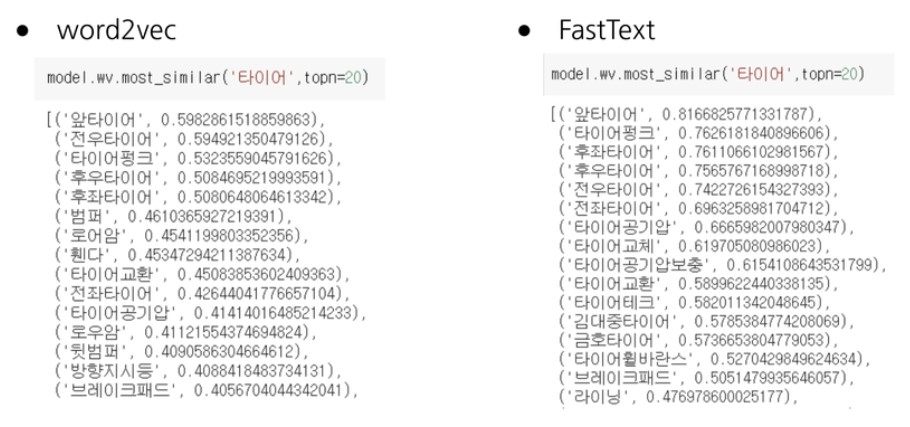

- [패스트텍스트(FastText)](https://wikidocs.net/22883)

### 6-4. 쏘카 메모 데이터

앞서 확인한 쏘카 메모 데이터에는 총 45개의 카테고리가 `inspect_type`컬럼에 정의되어 있다. 전체 행은 254,142개에 이른다. 그러나, 몇 개의 카테고리에는 세부적으로 나눌 수 있는 카테고리가 존재한다. 대표적으로 `일반수리`카테고리에 해당한다. `일반수리`카테고리는 52,094개의 행으로 이루어져 있다.

그래서 이번 스텝에서는 `일반수리`카테고리에 해당하는 메모 데이터를 다시 세부적인 수준으로 분류하는 과정을 순차적으로 나열해보고, 문제에 대한 해결 방안을 알아보고자 한다. 앞으로 진행하는 방법이 카테고리 분류에 있어 절대적인 정답이 아니라 해결할 수 있는 방법 중 하나라고 생각하면 된다.

<br>

**데이터 준비**

---
자동차 사전 로드

In [15]:
# load car dictionary
def load_car_dic():
    car_dic_file = open(PATH+'/carDic.txt', 'r')
    car_dic = set(car_dic_file.read().split('\n'))
    return car_dic
    
car_dic =load_car_dic()
print(len(car_dic)) # 4133

1433


쏘카 메모 데이터도 다시 불러오자. 데이터 원본 중에 필요한 컬럼만 남기고 nan이 들어있는 행도 삭제.

In [16]:
memo_data = pd.read_csv(PATH+'/car_inspect_info.tsv',
                        sep='\t',
                        lineterminator='\r')
memo_data = memo_data.drop(columns=['inspect_id', 'car_id', 'price']) # drop columns
memo_data = memo_data.dropna() # drop nan row
memo_data.head()

,inspect_at,inspect_type,description
0,2020-03-09,타이어수리(후우),조수석뒤타이어 현장펑크수리
1,2020-01-07,미션오일,단양애니카_미션오일 교환
2,2020-01-14,점화플러그,당진세계모터스_점화플러그 교환
3,2020-01-14,브레이크액,당진세계모터스-브레이크오일 교환
4,2020-01-06,브레이크액,당진세계모터스_브레이크오일 교환


문장을 토큰화 할 때 형태소 분석기 대신 앞서 언급한 subword 토크나이저인 SentencePiece를 사용해보자.

형태소 분석기 대신 SentencePiece를 사용하는 이유는 아래처럼 데이터 전체가 깔끔하게 정제되지 않는 경우(모두 붙여쓴 경우 등) 형태소 분석기는 잘못된 결과를 내보낼 가능성이 높기 때문이다. 따라서 지금부터는 SentencePiece를 사용하여 메모 카테고리 분석을 진행한다.

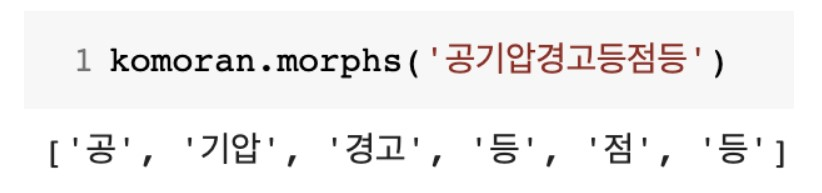

이제 학습에 사용될 데이터를 준비한다. 뉴스 기사 데이터 `KCC150_100k.txt`와 쏘카 메모 데이터 중 `description` 열을 모두 더해 사용한다. 학습 데이터를 이렇게 구성하는 이유는 쏘카 메모 데이터가 깔끔하게 전처리 되어있지 않았기 때문이다. 노이즈가 심한 데이터로만 구성하여 토크나이저를 학습시키면 올바른 토큰화가 이루어지지 않을 것이라고 판단해서이다.

아래 그림에서 첫 번째 결과처럼 토큰화가 불완전한 모습을 볼 수 있다. 두 데이터 셋을 섞어 올바르게 토큰화를 한다면 두 번째 결과처럼 좀 더 나은 결과물을 얻을 수 있다.

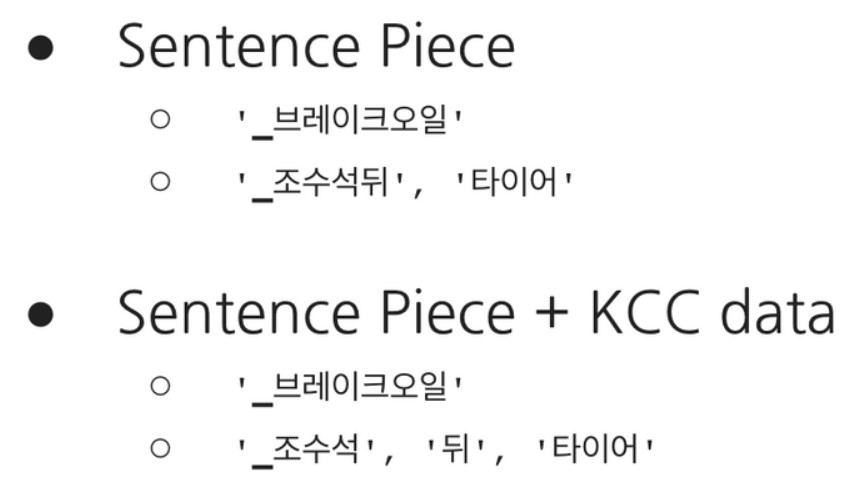

본격적으로 SentencePiece 학습 데이터를 구축하고 모델을 학습하여 토큰화에 적용하는 방법을 코드로 살펴보겠다.

SentencePiece를 학습하기 위해서는 Python의 string형태가 아니라 별도의 text파일로 저장되어야 한다. 아래 코드를 통해 학습 파일을 만들어 보자.

In [17]:
# sentencePiece를 학습하기 위해서는 별도의 text 파일이 필요함.
# 따라서 이를 만드는 부분
with open(PATH+'/car_info_description.txt', 'w') as w, open(PATH+'/KCC150_100k.txt','r') as corpus:
    w.write('\n'.join(memo_data['description']))
    for idx,snt in enumerate(corpus.readlines()):
        w.write(snt)

이제 준비된 `car_info_desription.txt`파일을 이용하여 학습을 진행

In [18]:
#SentencePiece Train & load
spm.SentencePieceTrainer.Train(f'--input={PATH}/car_info_description.txt --model_prefix={PATH}/description --vocab_size=6000')
sp = spm.SentencePieceProcessor()
vocab_file = PATH+'/description.model'
sp.load(vocab_file)

sentencepiece_trainer.cc(177) LOG(INFO) Running command: --input=/aiffel/aiffel/socar_memo/data/car_info_description.txt --model_prefix=/aiffel/aiffel/socar_memo/data/description --vocab_size=6000
sentencepiece_trainer.cc(77) LOG(INFO) Starts training with : 
trainer_spec {
  input: /aiffel/aiffel/socar_memo/data/car_info_description.txt
  input_format: 
  model_prefix: /aiffel/aiffel/socar_memo/data/description
  model_type: UNIGRAM
  vocab_size: 6000
  self_test_sample_size: 0
  character_coverage: 0.9995
  input_sentence_size: 0
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 4192
  num_threads: 16
  num_sub_iterations: 2
  max_sentencepiece_length: 16
  split_by_unicode_script: 1
  split_by_number: 1
  split_by_whitespace: 1
  split_digits: 0
  treat_whitespace_as_suffix: 0
  allow_whitespace_only_pieces: 0
  required_chars: 
  byte_fallback: 0
  vocabulary_output_piece_score: 1
  train_extremely_large_corpus: 0
  hard_

True

이제 쏘카 메모 데이터의 `description` 열에 SentencePiece를적용하여 토큰화하고 저장한다.

In [19]:
def to_token(df, col):
    '''
    make sentence to subword sentence
    '''
    morph_description = []
    for _, row in df.iterrows():
        memo = row[col]
        sp_out = sp.encode_as_pieces(memo.replace('_',' ').replace('-',' ').replace('/',' ').replace('ㄴ',' ').replace('#',' ').replace('=',' ').replace(')',' ) ').replace('(',' ( '))
        morph_description.append(' '.join([token.replace('▁','') for token in sp_out]))

    df["subword_description"] = morph_description
    return df

memo_data = to_token(memo_data, "description")
memo_data.head()

,inspect_at,inspect_type,description,subword_description
0,2020-03-09,타이어수리(후우),조수석뒤타이어 현장펑크수리,조수석 뒤 타이어 현장 펑크수리
1,2020-01-07,미션오일,단양애니카_미션오일 교환,단 양 애 니 카 미션오일 교환
2,2020-01-14,점화플러그,당진세계모터스_점화플러그 교환,당진세계모터스 점화플러그 교환
3,2020-01-14,브레이크액,당진세계모터스-브레이크오일 교환,당진세계모터스 브레이크오일 교환
4,2020-01-06,브레이크액,당진세계모터스_브레이크오일 교환,당진세계모터스 브레이크오일 교환


토큰화한 데이터를 이용해서 단어 벡터를 학습.

In [20]:
# Word2Vec train data processing
w2v_train = list(memo_data['subword_description'])
w2v_train = [line.split() for line in w2v_train]

# Word2Vec train part
model = gensim.models.word2vec.Word2Vec(w2v_train,
                                        vector_size=300,
                                        window=5,
                                        min_count=1,
                                        epochs=10)

### 6-5. 키워드 추출

`일반수리` 카테고리의 메모 데이터를 훑어보면 하나의 카테고리로 묶을 수 있지만, 그에 해당하는 종류가 너무 많아서 이를 하나로 묶는 경우가 더 나은 경우를 확인할 수 있다.

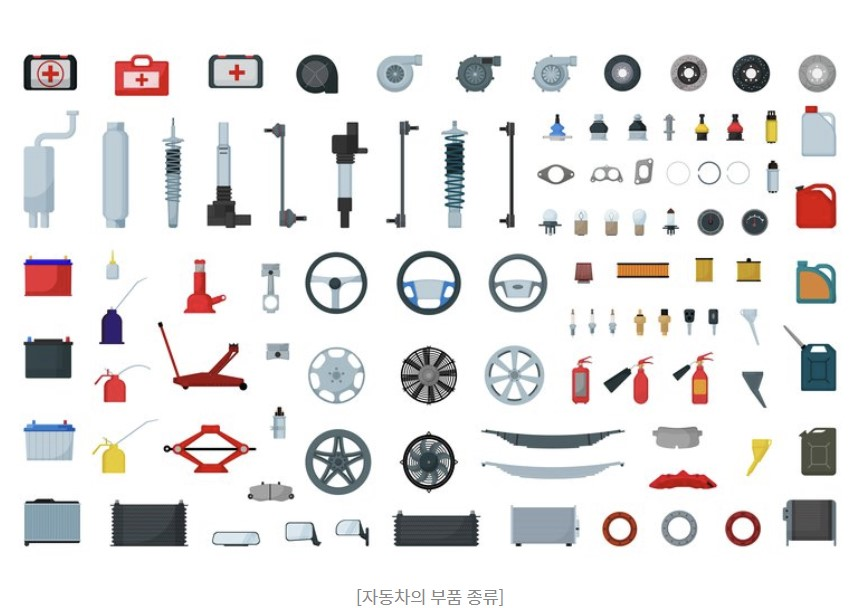

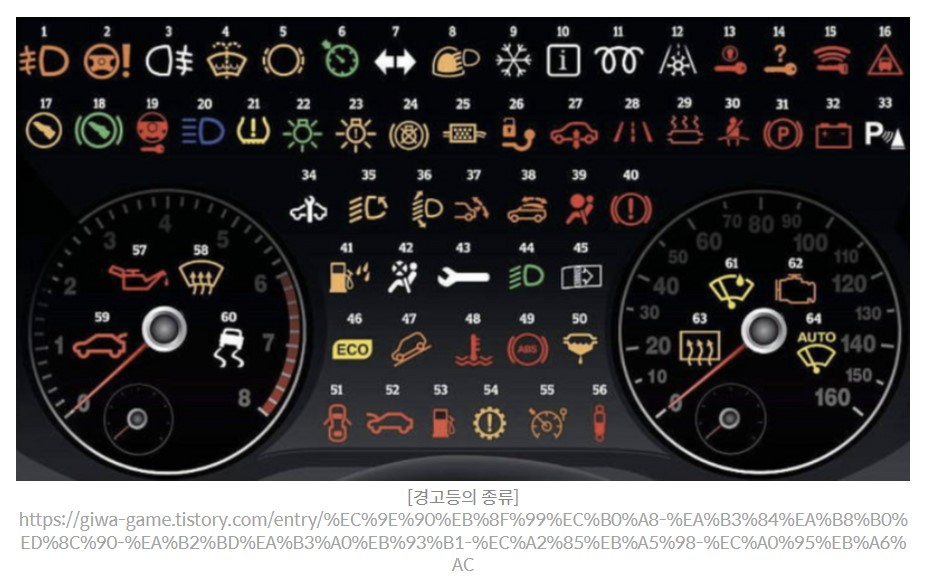

위 경우들을 모두 하나의 매핑 테이블로 묶어서 처리하게 되면, 여러 개로 퍼져있는 단어들을 포괄적으로 묶을 수 있다. 하지만 모든 경우를 수작업으로 묶기 어렵기 때문에 앞서 학습한 word2vec을 통해 유사한 단어들을 묶어보자.

word2vec은 단어간의 유사도를 파악하기에 용이하다. 아래 결과에서 하나의 단어에 대하여 유사한 단어들을 잘 표현함을 확인할 수 있다. 이러한 특징을 활용한 매핑테이블을 구성해보자.

In [21]:
# check word most similarity
model.wv.most_similar('타이어', topn=10)

[('전우타이어', 0.6180804371833801),
 ('앞타이어', 0.6015516519546509),
 ('전좌타이어', 0.5628288984298706),
 ('타이어펑크', 0.5413336157798767),
 ('후좌타이어', 0.512844443321228),
 ('바퀴', 0.49237051606178284),
 ('후우타이어', 0.48108524084091187),
 ('타이어교체', 0.4478299617767334),
 ('펑크', 0.4419485032558441),
 ('브레이크패드', 0.4290091395378113)]

In [22]:
model.wv.most_similar('경고등', topn=10)

[('엔진체크등', 0.681870698928833),
 ('공기압경고등', 0.6561216115951538),
 ('고장코드', 0.6426846981048584),
 ('기억', 0.5882686376571655),
 ('라이트경고등', 0.5668134689331055),
 ('체크', 0.5561351776123047),
 ('과거', 0.49468815326690674),
 ('코드', 0.4670996069908142),
 ('인근', 0.44756266474723816),
 ('진단기', 0.4415154755115509)]

만족스러운 결과이지만, 순위가 낮아질수록 상대적으로 입력 단어와 거리가 있는 것으로 보인다. 이를 해결하기 위해 단어 벡터에서 유사도가 평균값 이상인 경우만 선택한다. 아래 함수를 이용해서 유사한 단어만 추려보도록 하자.

In [23]:
def exclusion(word_list):
    '''
    most_similar의 단어를 평균 이상만 추림
    '''
    count = sum([score for _, score in word_list])
    avg = count / len(word_list)
    
    up_word = []
    for w, s in word_list:
        if s > avg:
            up_word.append(w)
            
    return up_word

In [24]:
# 라이트, 전구에서 나온 단어들 평균 이상만 저장
light = model.wv.most_similar('라이트', topn=20)
light_word = exclusion(light)
light = model.wv.most_similar('전구', topn=20)
light_word.extend(exclusion(light))

light_word.append('라이트')
light_word.append('전구')

light_word = set(light_word)

# 경고등도 평균 이상만 저장
error = model.wv.most_similar('경고등', topn=10)
error_word = exclusion(error)
error_word.append('경고등')

print(light_word)
print('')
print(error_word)

{'안개등', '브레이크전구', '미등', '전조등', '라이트', '주간', '실내등', '방향지시등', '하향등', '라이트전구', '주간주행등', '전구', '헤드라이트', '브레이크등', '헤드램프', '주행등', '백색더블'}

['엔진체크등', '공기압경고등', '고장코드', '기억', '라이트경고등', '체크', '경고등']


이제 이 단어들을 하나의 카테고리로 묶기 위한 매핑테이블을 작성해 보자.

매핑테이블이란 하나의 Key를 두고 여러 개의 Value를 Key에 연결시키는 것을 의미한다. `딜리버리`와 `탁송비`라는 Key에 `탁송`이라는 Value를 두어 `딜리버리`나 `탁송비`가 문장에서 출현하게 된다면 이를 `탁송`으로 매핑시켜주는 역할을 한다. 이러한 방법은 하나의 카테고리에서 다양한 단어가 나올 수 있는 경우에 고정된 카테고리로 묶어주는 역할을 한다. 아래 그림처럼 여러 개의 단어가 하나의 단어로 묶이게 되는 거다.

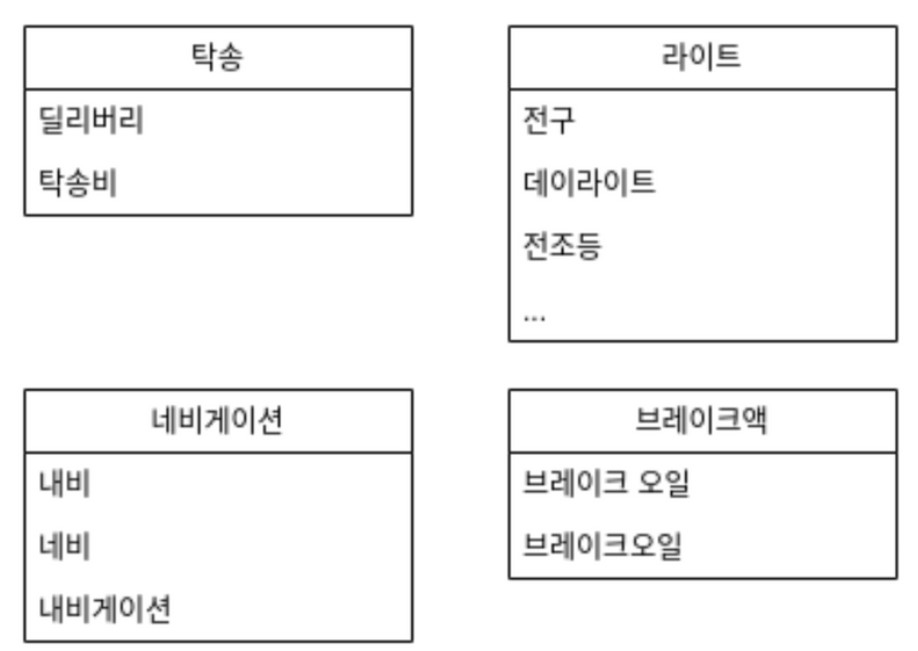

In [26]:
# 매핑 테이블 작성
mapping_table = {'내비게이션':'네비게이션', '내비':'네비게이션', '네비':'네비게이션', \
                  '딜리버리':'탁송', '탁송비':'탁송', \
                  '브레이크 오일':'브레이크액', '브레이크오일':'브레이크액', \
                  '라디오':'오디오'}

# "라이트" 관련 단어 매핑 테이블 추가
light_mapping = dict()
for word in light_word:
    light_mapping[word] = '라이트'
    
mapping_table.update(light_mapping)

# '경고등' 관련 단어 매핑 테이블 추가
error_mapping = dict()
for word in error_word:
    error_mapping[word] = '경고등'
    
mapping_table.update(error_mapping)

print(mapping_table)

{'내비게이션': '네비게이션', '내비': '네비게이션', '네비': '네비게이션', '딜리버리': '탁송', '탁송비': '탁송', '브레이크 오일': '브레이크액', '브레이크오일': '브레이크액', '라디오': '오디오', '안개등': '라이트', '브레이크전구': '라이트', '미등': '라이트', '전조등': '라이트', '라이트': '라이트', '주간': '라이트', '실내등': '라이트', '방향지시등': '라이트', '하향등': '라이트', '라이트전구': '라이트', '주간주행등': '라이트', '전구': '라이트', '헤드라이트': '라이트', '브레이크등': '라이트', '헤드램프': '라이트', '주행등': '라이트', '백색더블': '라이트', '엔진체크등': '경고등', '공기압경고등': '경고등', '고장코드': '경고등', '기억': '경고등', '라이트경고등': '경고등', '체크': '경고등', '경고등': '경고등'}


이제 문장에서 카테고리가 얼마나 나왔는지 카운팅 해보자.

우선 데이터에서 나타난 전체 카테고리는 몇 개 인지 확인해 본다.

In [28]:
# total category
category = set(memo_data['inspect_type'])
print(len(category))

45


총 45개의 카테고리가 존재함을 확인할 수 있다.

다음으로 문장 내에서 카테고리 내에 공백이 들어간 경우를 고려하기 위해 <br>
`noun_phrase` 함수를 만들어 준다. SentencePiece를 이용한 토큰화가 제대로 이루어지지 않을 가능성을 고려하여, 원래 문장을 어절 단위로 분절한 결과를 고려하여 카테고리를 찾는 `find_category` 함수를 작성한다.

In [32]:
def noun_phrase(words):
    result = []

    for index, token in enumerate(words):
        if (token in car_dic) or (token in category):
            #명사구 check
            if (''.join(words[index : index +2]) in car_dic) or (''.join(words[index : index +2]) in category):
                result.append(''.join(words[index : index +2]))
            #명사구 X
            result.append(token)
    return result

def find_category(row):
    # word base
    line = row['description'].replace('_',' ').replace('-',' ').replace('/',' ').replace('ㄴ',' ').replace('#',' ').replace('=',' ').replace(')',' ) ').replace('(',' ( ')
    car_token = noun_phrase(line.upper().split())
    # subword base
    car_token.extend(noun_phrase(row['subword_description'].upper().split()))
    return set(car_token)

이제 `일반수리` 열에서 자동차 사전에 기반한 sub 카테고리가 얼마나 출현했는지 카운팅한다.

In [33]:
subword_list = []
for _, row in memo_data.iterrows():
    if row['inspect_type'] == '일반수리':
        car_words = find_category(row) #find word in car_dic
    
        if len(car_words) >= 1:  #car_words more than one
            subword_list.extend(car_words)

subword_list = [subword for subword in subword_list if subword != '']
subword_counter = Counter(subword_list) #car_dic에 포함되는 단어 + category에 포함되는 단어
subword_sort = sorted(subword_counter.items(), key=lambda x:x[1], reverse=True)
subword_top20 = [(key, value) for key, value in subword_sort[:20]]

print(subword_top20)

[('전구', 4971), ('엔진', 1931), ('전조등', 1380), ('브레이크', 1321), ('타이어', 824), ('센서', 609), ('시트', 581), ('도어', 528), ('유리', 510), ('휠', 497), ('에어컨', 482), ('디스크', 465), ('장애처리', 459), ('스로틀바디', 454), ('제동등', 432), ('연료', 396), ('커버', 341), ('범퍼', 320), ('배터리', 305), ('암', 300)]


### 6-6. 키워드 분류

앞에서 만든 결과를 토대로 이제 카테고리를 다시 분류해 볼 예정이다.

분류를 위한 함수 정의

In [27]:
def re_ranking(word_list):
    '''
    이전에 카테고리 카운팅된 subword_counter를 기준으로 Recategoring
    IF. 2개 이상의 카테고리 단어가 한 문장에서 등장할 경우, max 값 카테고리를 취함.
    '''
    
    max_word = (None, -99)
    for word in word_list:
        # 단어가 mapping table에 포함되는 경우
        # mapping table Key word를 반환함
        if word in mapping_table:
            word = mapping_table.get(word)
            
        # 단어가 2개 이상 선택되는 경우, 고빈도 word를 취함.
        if subword_counter[word] > max_word[1]:
            max_word = (word, subword_counter[word])
            
    return max_word[0]

`re_ranking` 함수를 앞서 계산한 `subword_counter`를 기준으로 한 문장에서 2개 이상의 카테고리 단어가 출현한 경우, 결과 중에서 최댓값을 갖는 카테고리를 최종 카테고리로 선정하게 만드는 함수이다. 즉, 여러 개의 단어가 있을 때, 다시 최종 카테고리를 정해주는 것이다.

이제 이 함수를 이용해서 재분류 작업을 진행하겠다.

In [35]:
'''
find more best category from 일반수리
'''
category_count = 0
recategory_count = 0
recategory = []
for _, row in memo_data.iterrows():
    if row['inspect_type'] == '일반수리':
        carWords = find_category(row) # find word in carDic
        recat = re_ranking(carWords)
        recategory.append(recat)
        
        category_count += 1
        if recat != None:
            recategory_count += 1
            
    else:
        recategory.append(None)
        
memo_data['recategory'] = recategory # append recategory columns

memo_data = memo_data[['inspect_at', 'inspect_type', 'recategory', 'description', 'subword_description']] # change columns order
memo_data.to_csv(PATH+'/car_inspect_info_NEW.tsv', mode='w')

memo_data.head()

,inspect_at,inspect_type,recategory,description,subword_description
0,2020-03-09,타이어수리(후우),None,조수석뒤타이어 현장펑크수리,조수석 뒤 타이어 현장 펑크수리
1,2020-01-07,미션오일,None,단양애니카_미션오일 교환,단 양 애 니 카 미션오일 교환
2,2020-01-14,점화플러그,None,당진세계모터스_점화플러그 교환,당진세계모터스 점화플러그 교환
3,2020-01-14,브레이크액,None,당진세계모터스-브레이크오일 교환,당진세계모터스 브레이크오일 교환
4,2020-01-06,브레이크액,None,당진세계모터스_브레이크오일 교환,당진세계모터스 브레이크오일 교환


최종적으로 `일반수리` 카테고리에 있어서 다시 sub 카테고리로 나눠진 경우는 `recategory` 열에 추가하여 `car_inspect_info_NEW.tsv` 파일로 저장하였다.

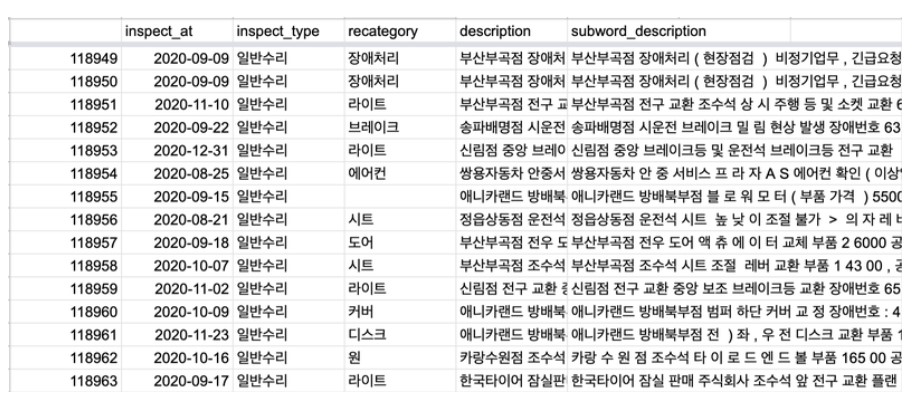

마지막으로 기존 `일반수리` 카테고리 52,094 행 중 19,928 행을 sub 카테고리로 변환한 것을 확인해보자.

In [37]:
print(f'일반수리 카테고리 개수: {category_count}')
print(f'일반수리 카테고리 중 sub 카테고리 변경 개수: {recategory_count}')

일반수리 카테고리 개수: 52094
일반수리 카테고리 중 sub 카테고리 변경 개수: 19928


sub 카테고리의 개수 카운팅

In [39]:
recategory_counter = Counter(recategory)
recategory_counter_sorted = sorted(recategory_counter.items(), key=lambda x:x[1], reverse=True)
recategory_top20 = [(key, value) for key, value in recategory_counter_sorted[:21]]

print(recategory_top20)

[(None, 234214), ('라이트', 4895), ('엔진', 1931), ('브레이크', 1310), ('타이어', 797), ('시트', 574), ('센서', 543), ('도어', 508), ('유리', 489), ('에어컨', 462), ('장애처리', 441), ('휠', 429), ('스로틀바디', 427), ('제동등', 420), ('디스크', 380), ('연료', 324), ('배터리', 279), ('범퍼', 264), ('암', 263), ('엔진오일', 244), ('TCS', 239)]


### 6-7. 시각화

앞에서나온 결과를 토대로 시간의 흐름에 따른 경향성을 파악해보자.

우선 시간의 흐름을 보기 위해 날짜에 해당하는 데이터를 string에서 datetime으로 수정한다.

In [40]:
# 일반수리에 해당하는 row만 추림
normal = memo_data.loc[memo_data['inspect_type'] == '일반수리'].copy()

# pandas inspect_at column to datetime object
normal['dates'] = pd.to_datetime(normal['inspect_at'], format='%Y-%m-%d', errors='raise')

normal.head()

,inspect_at,inspect_type,recategory,description,subword_description,dates
113553,2020-05-12,일반수리,라이트,전구 1개,전구 1 개,2020-05-12
113554,2020-06-26,일반수리,None,네비거치대,네비거치대,2020-06-26
113555,2020-06-23,일반수리,라이트,더블전구 1개,더 블 전구 1 개,2020-06-23
113556,2020-06-29,일반수리,라이트,더블 전구 2개,더 블 전구 2 개,2020-06-29
113557,2020-06-23,일반수리,None,주간주행등 교환,주간주행등 교환,2020-06-23


데이터를 월별 시각화.

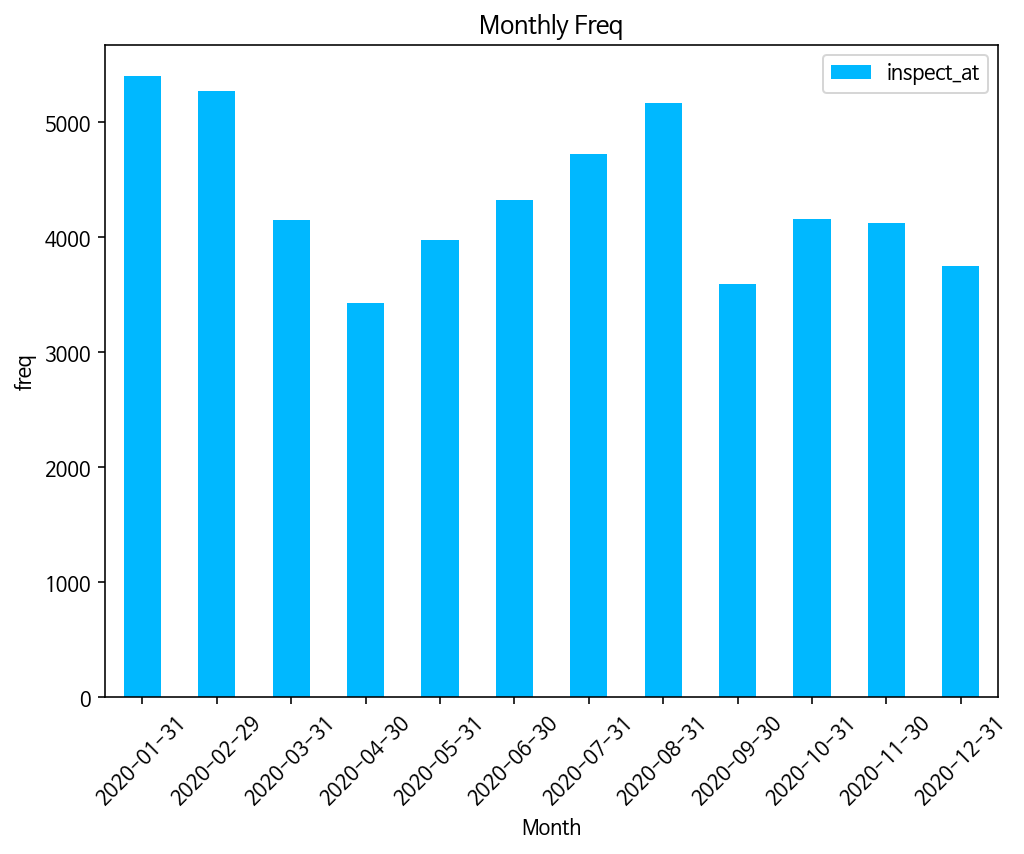

In [41]:
monthly = normal.groupby(pd.Grouper(key='dates', freq='M')).count()
monthly = monthly['inspect_at']
monthly = monthly.reset_index() # dates가 index인데, 이를 제거해줌(column으로 변경)
monthly['dates_str'] = monthly['dates'].apply(lambda x: str(x)[:10]) # datetime to str

plt.rcParams["figure.figsize"] = (8, 6)
monthly.plot(x='dates_str', y='inspect_at', color='#00B8FF', kind='bar')

plt.xticks(rotation=45)
plt.title('Monthly Freq')
plt.xlabel('Month')
plt.ylabel('freq')

plt.savefig(PATH+'/Monthly_freq.png')
plt.show()

이제 sub 카테고리의 top5 항목에 대해서만 발생 경향성을 파악해보자.

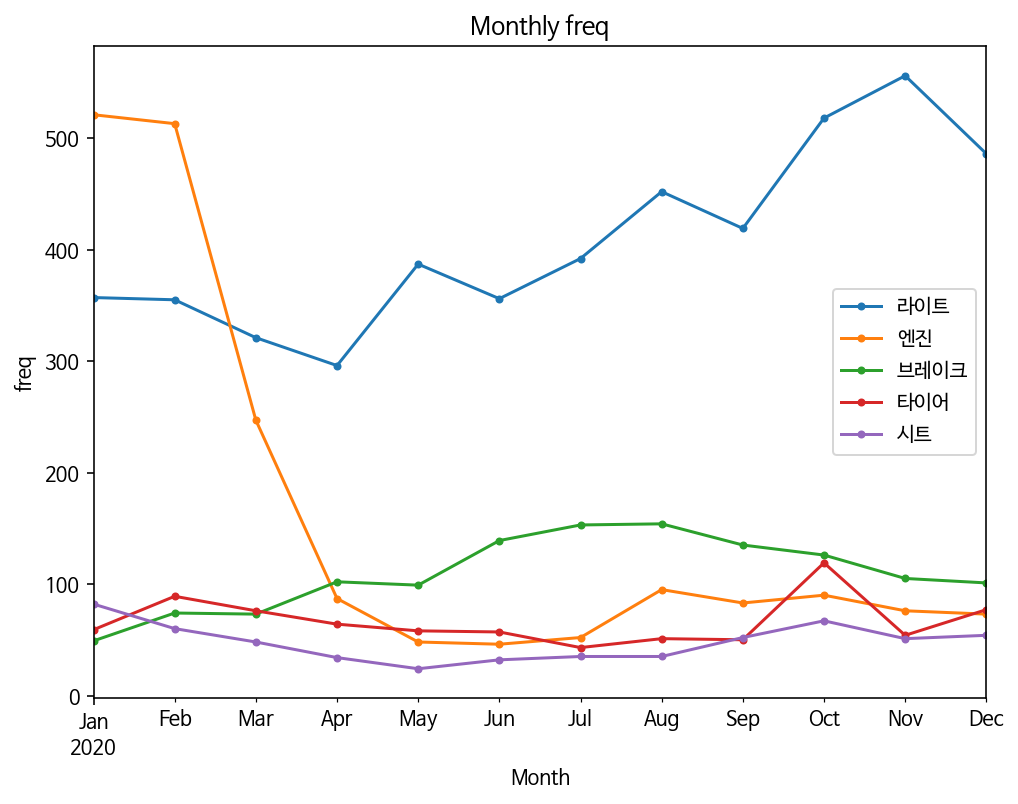

In [43]:
# recategory freq Top 5
temp = pd.DataFrame()
for word, count in recategory_top20[1:6]:
    temp[word] = normal.groupby(pd.Grouper(key='dates', freq='M'))['recategory'].apply(lambda x: x[x == word].count())
    
temp.plot(marker='.')
plt.title('Monthly freq')
plt.xlabel('Month')
plt.ylabel('freq')
plt.savefig(PATH+'/recategory_top5.png')
plt.show()

sub 카테고리 top 6~10

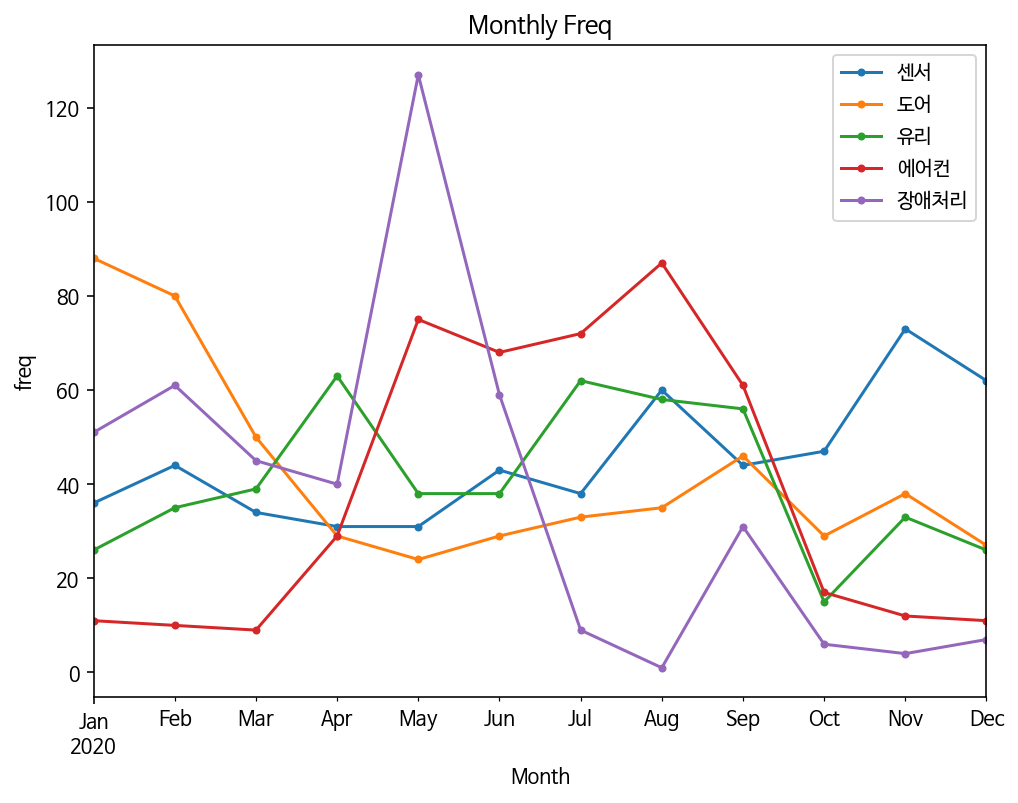

In [44]:
# recategory freq Top 6-10
temp = pd.DataFrame()
for word, count in recategory_top20[6:11]:
    temp[word] = normal.groupby(pd.Grouper(key='dates', freq='M'))['recategory'].apply(lambda x: x[x == word].count())

temp.plot(marker='.')
plt.title('Monthly Freq')
plt.xlabel('Month')
plt.ylabel('freq')
plt.savefig(PATH+'/recategory_6_10.png')
plt.show()

이렇게 쏘카에서 수리되는 카테고리를 계절별로 한 눈에 볼 수 있게 되었다.